**Laboratorio N°4 - SIS420**

**Introducción.**

En este cuadernillo, para este laboratorio, nos enfocaremos en el entrenamiento y evaluación de modelos de regresión logística (one vs all). Utilizaremos cada uno de los datasets anteriores para la realización de predicciones, contando ahora con el hiperparámetro de regularización, el cual nos ayudará a hacer las respectivas comparaciones durante el entrenamiento, pues se pondrá al modelo a prueba usando este hiperparámetro y sin usar este hiperparámetro.

**Objetivos.**

- Seleccionar y preparar los respectivos datasets anteriores que contienen las variables necesarias para el entrenamiento de modelos de regresión logística.
- Implementar modelos de regresión logística.
- Entrenar y validar cada modelo comparando las predicciones realizadas con el modelo con los datos de las hipótesis ya establecidas
- Evaluar la efectividad de cada modelo mediante la realización de predicciones y la medición de métricas de desempeño.
- Utilizar la biblioteca Pandas para manipular y procesar los datos del dataset.
Generar gráficos de costo para analizar el proceso de entrenamiento de los modelos.

In [1]:
print(f"Laboratorio N°4 - SIS420: Limachi Villarroel Alan Nicolas.")
print(f"Carrera: Ingeniería en Ciencias de la Computación.")

Laboratorio N°4 - SIS420: Limachi Villarroel Alan Nicolas.
Carrera: Ingeniería en Ciencias de la Computación.


**(0) Montar Google Drive en Colaboratoy.** Una vez que el Google Drive está montado, puedes acceder a los archivos almacenados en tu Google Drive directamente desde el entorno de Colaboratory.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**(1) Preparación librerías y funciones para los modelos.** En este caso se prepararán las respectivas librerías para trabajar de forma más directa y sencilla con cada modelo, además de crear las funciones que se utilizarán para cada uno de estos modelos, creando así un código más legible, limpio, de forma que se entienda mejor cada algoritmo determinado.


**(a) Determinación de las Librerías.**
Se explicará de forma simple el uso de estas librerías en este cuadernillo para un mejor entendimiento:
- import os: Interactuar con el sistema operativo.
- import pandas as pd: Manipular y analizar datos tabulares.
- import numpy as np: Computación numérica eficiente.
- from matplotlib import pyplot as plt: Visualizar datos y gráficos.
- from mpl_toolkits.mplot3d import Axes3D: Visualizar datos tridimensionales.
- from sklearn.linear_model import LinearRegression: Implementar regresión lineal.
- from sklearn.preprocessing import PolynomialFeatures: Crear características polinómicas.
- from sklearn.metrics import mean_squared_error: Evaluar el error cuadrático medio.
- from scipy import optimize: Optimizar funciones matemáticas.
from sklearn.model_selection import train_test_split: Dividir datos en entrenamiento y prueba.
- from sklearn.preprocessing import StandardScaler: Estandarizar características numéricas.
- import shutil: Manipular archivos y directorios.


In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil
%matplotlib inline

**(b) Determinación de las funciones.**

In [ ]:
class Model:
    def __init__(self, dataset):
      self.dataset = self.prepocesarDataset(dataset)
      self.train_set, self.test_set = train_test_split(self.dataset, test_size=0.2, random_state=99)
      self.X_train, self.y_train = self.train_set.iloc[:, :-1], self.train_set.iloc[:, -1]
      self.X_test, self.y_test = self.test_set.iloc[:, :-1], self.test_set.iloc[:, -1]
      self.X_train = np.concatenate([np.ones((self.X_train.shape[0], 1)), self.X_train], axis=1)
      self.X_test = np.concatenate([np.ones((self.X_test.shape[0], 1)), self.X_test], axis=1)
      self.J = 0
    def normalizarCaracteristicas(self, X):
      media = np.mean(X, axis=0)
      desviacion_estandar = np.std(X, axis=0)
      desviacion_estandar[desviacion_estandar == 0] = 1
      X_norm = (X - media) / desviacion_estandar
      return X_norm
    def graficarCosto(self, J):
      plt.plot(np.arange(len(J)), J, lw=2)
      plt.xlabel('Numero de iteraciones')
      plt.ylabel('Costo J')
    def calcularPorcentajeAcierto(self):
      predicciones = self.realizarPredicciones(self.X_test, self.theta)
      predicciones_redondeadas = np.round(predicciones)
      precision = np.mean(predicciones_redondeadas == self.y_test) * 100
      print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))
    def prepocesarDataset(self, dataset):
      dataset = pd.read_csv(dataset, sep=';', header=0, decimal=',')
      datos = {}
      columnas = dataset.columns[dataset.dtypes == 'object'].tolist()
      for columna in columnas:
        datos[columna] = dataset[columna].drop_duplicates().values
      datos_num = {}
      for columna, valores in datos.items():
        indice_reemp = 0
        datos_num_col = {}
        for valor in valores:
          if valor not in datos_num_col and not pd.isnull(valor):
            datos_num_col[valor] = indice_reemp
            indice_reemp += 1
        if np.nan not in datos_num_col:
          datos_num_col[np.nan] = 0
        datos_num[columna] = datos_num_col
      for columna, d_n in datos_num.items():
        dataset[columna] = dataset[columna].replace(d_n)
      dataset = dataset.fillna(0)
      return dataset

**(2) Creación de los modelos.**

**(a) Regresión Logística.**

In [ ]:
class ModelLogistica(Model):
  def entrenar(self, regularizacion):
      self.lambda_ = 0.01 if regularizacion else 0
      self.X_test = self.normalizarCaracteristicas(self.X_test)
      self.X_train = self.normalizarCaracteristicas(self.X_train)
      self.theta = np.zeros(self.X_train.shape[1])
      self.theta, self.J = self.descensoGradiente(self.X_train, self.y_train, self.theta, self.lambda_, 1000)
      self.graficarCosto(self.J)
  def funcionSigmoide(self, z):
    return 1 / (1 + np.exp(-z))
  def funcionCosto(self, X, y, theta):
    m = y.size
    h = self.funcionSigmoide(X @ theta)
    costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    if self.lambda_ != 0:
      regularizacion = (self.lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
      costo += regularizacion
    return costo
  def descensoGradiente(self, X, y, theta, lambda_, num_iteraciones):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []
    for _ in range(num_iteraciones):
        h = self.funcionSigmoide(X @ theta)
        gradiente = (1 / m) * (X.T @ (h - y))
        if lambda_ != 0:
            regularizacion = (lambda_ / m) * theta
            regularizacion[0] = 0
            gradiente += regularizacion
        theta -= gradiente
        J_history.append(self.funcionCosto(X, y, theta))
    return theta, J_history
  def realizarPredicciones(self, X, theta):
    probabilidad = self.funcionSigmoide(X @ theta)
    predicciones = (probabilidad >= 0.5).astype(int)
    return predicciones
  def calcularPorcentajeAcierto(self):
    predicciones = self.realizarPredicciones(self.X_test, self.theta)
    predicciones_redondeadas = np.round(predicciones)
    precision = np.mean(predicciones_redondeadas == self.y_test) * 100
    print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

**(b) Regresión Logística (One vs All).**

In [ ]:
class ModelOnevsAll(Model):
    def entrenar(self, regularizacion):
        self.lambda_ = 0.01 if regularizacion else 0
        self.X_test = self.normalizarCaracteristicas(self.X_test)
        self.X_train = self.normalizarCaracteristicas(self.X_train)
        self.theta = self.descensoGradiente(self.X_train, self.y_train, self.lambda_, 1000)
    def funcionSigmoide(self, z):
        return 1 / (1 + np.exp(-z))
    def funcionCosto(self, theta, X, y, lambda_):
      m = y.size
      h = self.funcionSigmoide(X @ theta)
      costo = (1 / m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
      if lambda_ != 0:
        regularizacion = (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
        costo += regularizacion
      gradiente = (1 / m) * (X.T @ (h - y))
      if lambda_ != 0:
        regularizacion_gradiente = (lambda_ / m) * theta
        regularizacion_gradiente[0] = 0
        gradiente += regularizacion_gradiente
      return costo, gradiente
    def descensoGradiente(self, X, y, lambda_, num_iteraciones):
      m, n = X.shape
      num_labels = len(np.unique(y))
      theta = np.zeros((num_labels, n))
      for c in np.arange(num_labels):
        initial_theta = np.zeros(n)
        y_onevsall = (y == c).astype(int)
        cost_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[0]
        grad_function = lambda t, X, y, lambda_: self.funcionCosto(t, X, y, lambda_)[1]
        res = optimize.minimize(cost_function, initial_theta, args=(X, y_onevsall, lambda_), jac=grad_function, method='CG', options={'maxiter': num_iteraciones})
        theta[c] = res.x
      return theta
    def realizarPredicciones(self, X, theta):
        m = X.shape[0]
        probabilidades = self.funcionSigmoide(X @ theta.T)
        predicciones = np.argmax(probabilidades, axis=1)
        return predicciones
    def calcularPorcentajeAcierto(self):
        predicciones = self.realizarPredicciones(self.X_test, self.theta)
        predicciones_redondeadas = np.round(predicciones)
        precision = np.mean(predicciones_redondeadas == self.y_test) * 100
        print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

**(3) Entrenamiento y predicciones relizadas por los modelos.**

**(a) Modelo de Regresión Logística.**

*(i) Carga del Dataset.*

In [ ]:
datasetLogistica = '/content/gdrive/MyDrive/SIS420/Laboratorio_4_SIS420/Datasets/trastorno_genético.csv'
lSR = ModelLogistica(datasetLogistica)
lCR = ModelLogistica(datasetLogistica)

*(ii) Entrenamiento y predicciones sin el hiperparámetro.*

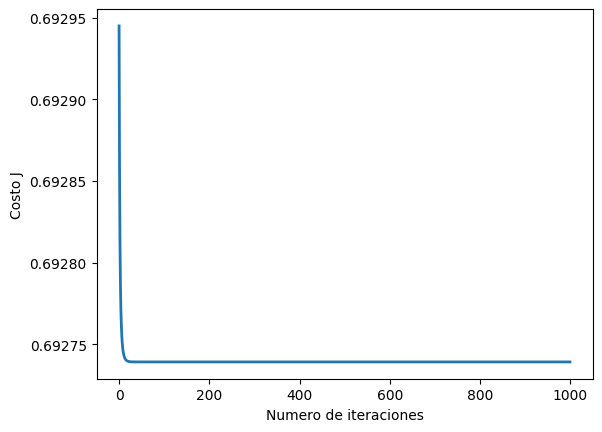

In [ ]:
lSR.entrenar(False)

In [ ]:
lSR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 49.1901728844%


*(iii) Entrenamiento y predicciones con el hiperparámetro.*

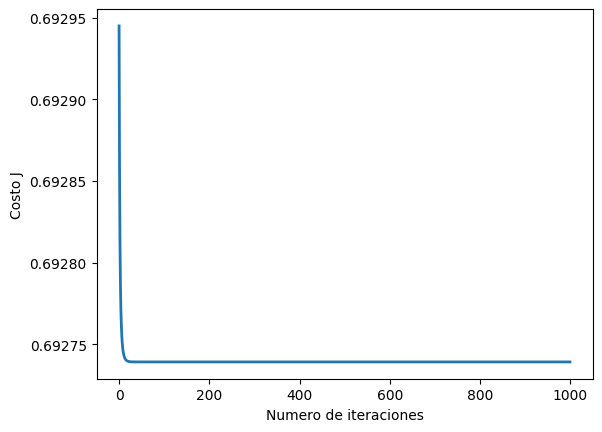

In [ ]:
lCR.entrenar(True)

In [ ]:
lCR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 49.1901728844%


In [ ]:
print(lSR.lambda_)
print(lSR.descensoGradiente(lSR.X_train, lSR.y_train, lSR.theta, lSR.lambda_, 100)[0])
print(lCR.lambda_)
print(lCR.descensoGradiente(lCR.X_train, lCR.y_train, lCR.theta, lCR.lambda_, 100)[0])

0
[ 0.          0.00225061  0.00224665  0.00225061  0.00224665  0.00224665
  0.         -0.02976009  0.01146083 -0.01434687  0.01402643 -0.02486977
 -0.00253581 -0.00588417 -0.01339917  0.01150257  0.01460511 -0.01110315
  0.00698584  0.01110141 -0.01272589 -0.00012441 -0.00947206 -0.0040436 ]
0.01
[ 0.          0.00225061  0.00224665  0.00225061  0.00224665  0.00224665
  0.         -0.02976003  0.01146081 -0.01434685  0.01402639 -0.02486972
 -0.00253582 -0.00588417 -0.01339913  0.01150253  0.01460506 -0.0111031
  0.00698581  0.01110136 -0.01272584 -0.00012442 -0.00947203 -0.00404359]


**(b) Modelo de Regresión Logística (One vs All).**

*(i) Carga del Dataset.*

In [ ]:
datasetOnevsAll = '/content/gdrive/MyDrive/SIS420/Laboratorio_4_SIS420/Datasets/trastorno_genético.csv'
oSR = ModelOnevsAll(datasetOnevsAll)
oCR = ModelOnevsAll(datasetOnevsAll)

*(ii) Entrenamiento y predicciones sin el hiperparámetro.*

In [ ]:
oSR.entrenar(False)

In [ ]:
oSR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 61.9809825674%


*(iii) Entrenamiento y predicciones con el hiperparámetro.*

In [ ]:
oCR.entrenar(True)

In [ ]:
oCR.calcularPorcentajeAcierto()

Precisión de las predicciones en el conjunto de prueba: 62.0443740095%


In [ ]:
print(oSR.lambda_)
print(oSR.descensoGradiente(oSR.X_train, oSR.y_train, oSR.lambda_, 100)[0])
print(oCR.lambda_)
print(oCR.descensoGradiente(oCR.X_train, oCR.y_train, oCR.lambda_, 100)[0])

0
[ 0.          0.01640715 -0.07621439  0.06631062 -0.18681803  0.08436521
  0.00718702 -0.01911546 -0.05216193 -0.16580614  0.07419576  0.06654683
 -0.6813899  -0.65751693 -0.65219899 -0.64241182 -0.65116373  0.67128517
  0.15896705  0.1418954   0.10075378  0.22982588  0.17803186  0.14044671
  0.10792295  0.1185572   0.16939076  0.16404331 -0.65366537  0.12596424
 -0.94404933  0.17206971 -0.14808227 -0.15651766 -0.16777338 -0.11659645
 -0.05594077 -0.59671031]
0.01
[ 0.          0.01640717 -0.07621362  0.06630984 -0.18681686  0.08436435
  0.00718702 -0.01911424 -0.05216028 -0.16580225  0.07419572  0.06654717
 -0.68138369 -0.65751133 -0.65219389 -0.64240678 -0.65115845  0.67127867
  0.1589671   0.14189523  0.10075389  0.22982164  0.17803143  0.14044683
  0.1079231   0.11855721  0.16939038  0.16404305 -0.65365992  0.12596456
 -0.94402888  0.17207108 -0.14809001 -0.15651871 -0.16777426 -0.11659783
 -0.05594264 -0.59669846]


**(4) Comparación con Modelos ya prehechos.**

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def entrenar_modelo_logistica_sklearn(X_train, y_train, X_test, y_test, regularizacion=True):
    if regularizacion:
        modelo = LogisticRegression(penalty='l2', C=0.01)
    else:
        modelo = LogisticRegression(penalty='none')
    modelo.fit(X_train, y_train)
    precision = modelo.score(X_test, y_test) * 100
    print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

def entrenar_modelo_one_vs_all_sklearn(X_train, y_train, X_test, y_test, regularizacion=True):
    classifier =  SVC()
    classifier.fit(X_train, y_train)
    precision = classifier.score(X_test, y_test) * 100
    print("Precisión de las predicciones en el conjunto de prueba: {:.10f}%".format(precision))

In [ ]:
entrenar_modelo_logistica_sklearn(lCR.X_train, lCR.y_train, lCR.X_test, lCR.y_test) #74.96%
entrenar_modelo_one_vs_all_sklearn(oCR.X_train, oCR.y_train, oCR.X_test, oCR.y_test) #55.69%